# Dataset Selection

- Datasets: 191

- Samples: 29.198

### OpenRefine:
A powerful free, open source tool for working with messy data: cleaning it, transforming it from one format into another and extending it with web services and external data.

- Retrieve platform *technology* from [Gene Expression Omnibus](https://0-www-ncbi-nlm-nih-gov.brum.beds.ac.uk/geo/browse/?view=platforms):

  - high-throughput sequencing (64 datasets: 1473 samples)

  - spotted oligonucleotide (35 datasets: 24.119 samples)

  - in situ oligonucleotide (61 datasets: 2987 samples)

  - RT-PCR (28 datasets: 544 samples)

  - other (3 datasets: 75 samples)

- Delete datasets:

  - *technology* = other | [RT-PCR](https://biosistemika.com/blog/qpcr-microarrays-rna-sequencing-choose-one)

  - *dataset* = EMIR00000180 (64 samples) ([samples in common with EMIR00000177 but inconsistent values](./report.numbers))

  - *dataset* = EMIR00000091 | EMIR00000092 | EMIR00000097 | EMIR00000101 (subsets of EMIR00000102)

  - *dataset* = EMIR00000010 | EMIR00000011 | EMIR00000023 | EMIR00000026 | EMIR00000028 | EMIR00000038 | EMIR00000081 | EMIR00000095 | EMIR00000096 | EMIR00000123 | EMIR00000133 | EMIR00000137 | EMIR00000158 (441 samples) (Non-disease: e.g. Human mesenchymal stem cell, Hair follicle regeneration, Wound healing and myoblast formation)

# Metadata Preprocessing

- Features: 267

### OpenRefine

- Add dataset-level features.

- Split and transpose key:value features.

- Delete samples:

   - *organism* ≠ Homo sapiens (22 samples)

   - *channel_count* ≠ 1 (189 samples)

   - *molecule* ≠ total RNA (2 samples)

   - Disease status not clear (EMIR00000090: 13, EMIR00000008: 4, EMIR00000067: 3, EMIR00000102: 30, EMIR00000168: 9)

In [14]:
import pandas as pd


def keep_first_occurrence(row):
    """
    Delete repeated occurrences of the same value in a row
    """
    new_row = []
    for value in row:
        new_row.append(value if value not in new_row else None)
    return pd.Series(new_row, index=row.index)


metadata = pd.read_csv('data/PD.csv', dtype=str).apply(keep_first_occurrence, axis=1)

# Remove columns containing a unique value for all the rows
metadata.drop(metadata.columns[metadata.apply(pd.Series.nunique) == 1], axis=1, inplace=True)

# Remove empty columns
metadata.dropna(axis=1, how='all', inplace=True)

metadata.to_csv('data/PD.csv', index=False)

### OpenRefine

- Merge equivalent features associated to different datasets.

- Rename features consistently.

- Delete irrelevant or redundant features (e.g. *state* has an almost 1:1 relationship with *city*).

- Delete features where missing values ⪆ 98%.

- Refine dataset-level features (based on majority class) using sample-level data: *disease*, *disease_type*, *body_site*.
        
- Detect healthy samples in each dataset exploiting sample description.

- Extract *metastasis* and *stage* from sample description.

- Standardize *age*, *sex*, *city*, *disease*, *disease_type* values.

# miRNA Preprocessing 

In [125]:
import pandas as pd


name_conversions = {}
for _, row in pd.read_csv('data/raw/converter.csv', index_col=0).iterrows():
    for i in range(len(row) - 1):
        if row[i] != row[-1]:
            name_conversions[row[i]] = row[-1]
            

def transform_miRNA_name(name):
    """
    Delete whitespaces, standardize separators and remove version suffix from miRNA names. Update miRNA names to the latest version of miRBase.
    """
    name = name.replace(' ', '')
    name = name.replace(',hsa', '|hsa')
    name = name.replace('+hsa', '|hsa')
    name = name.replace('/hsa', '|hsa')
    name = name.replace('_hsa', '|hsa')
    name = name.split('_v1')[0]
    name = name.split('_v2')[0]
    name = name_conversions.get(name, name)
    return name


samples_per_dataset = pd.read_csv('data/PD.csv').groupby('dataset')['sample_id'].agg(list).to_dict()
df_list = []

for dataset in samples_per_dataset.keys():

    df = pd.read_csv(f'data/raw/exp/{dataset}_exp.csv', converters={0: transform_miRNA_name})

    # Delete rows indexed by the same miRNA name (dataset anomaly)
    df = df.drop_duplicates(df.columns[0])

    # Delete rows indexed by miRNA names containing 'plus', 'novel' (unknown miRNA), 'hsa-miR-647+a703' (dataset anomaly), '_var2' (dataset contains identical suffix-free miRNA)
    df = df[df[df.columns[0]].str.contains('plus|novel|hsa-miR-647\+a703|_var2') == False]

    # Transpose data
    df = df.set_index(df.columns[0]).T

    # Remove samples not included in metadata
    df = df.loc[samples_per_dataset[dataset]]
    
    df_list.append(df)

# Concatenate data into a single dataframe
values = pd.concat(df_list)

pd.DataFrame(values.count(axis=0), columns=['samples']).to_csv('data/miRNA.csv')
values.to_csv('data/EXP.csv')

- [Converter](http://mirandola.iit.cnr.it/converter.php)

- [Plus](https://www.tecan.com/hubfs/Tecan_Journal/200702/TecanJournal2007-02_page_16.pdf)

- [Novel](https://academic.oup.com/bfg/article/15/1/65/1742523)

# Visualization

Total samples: 27649


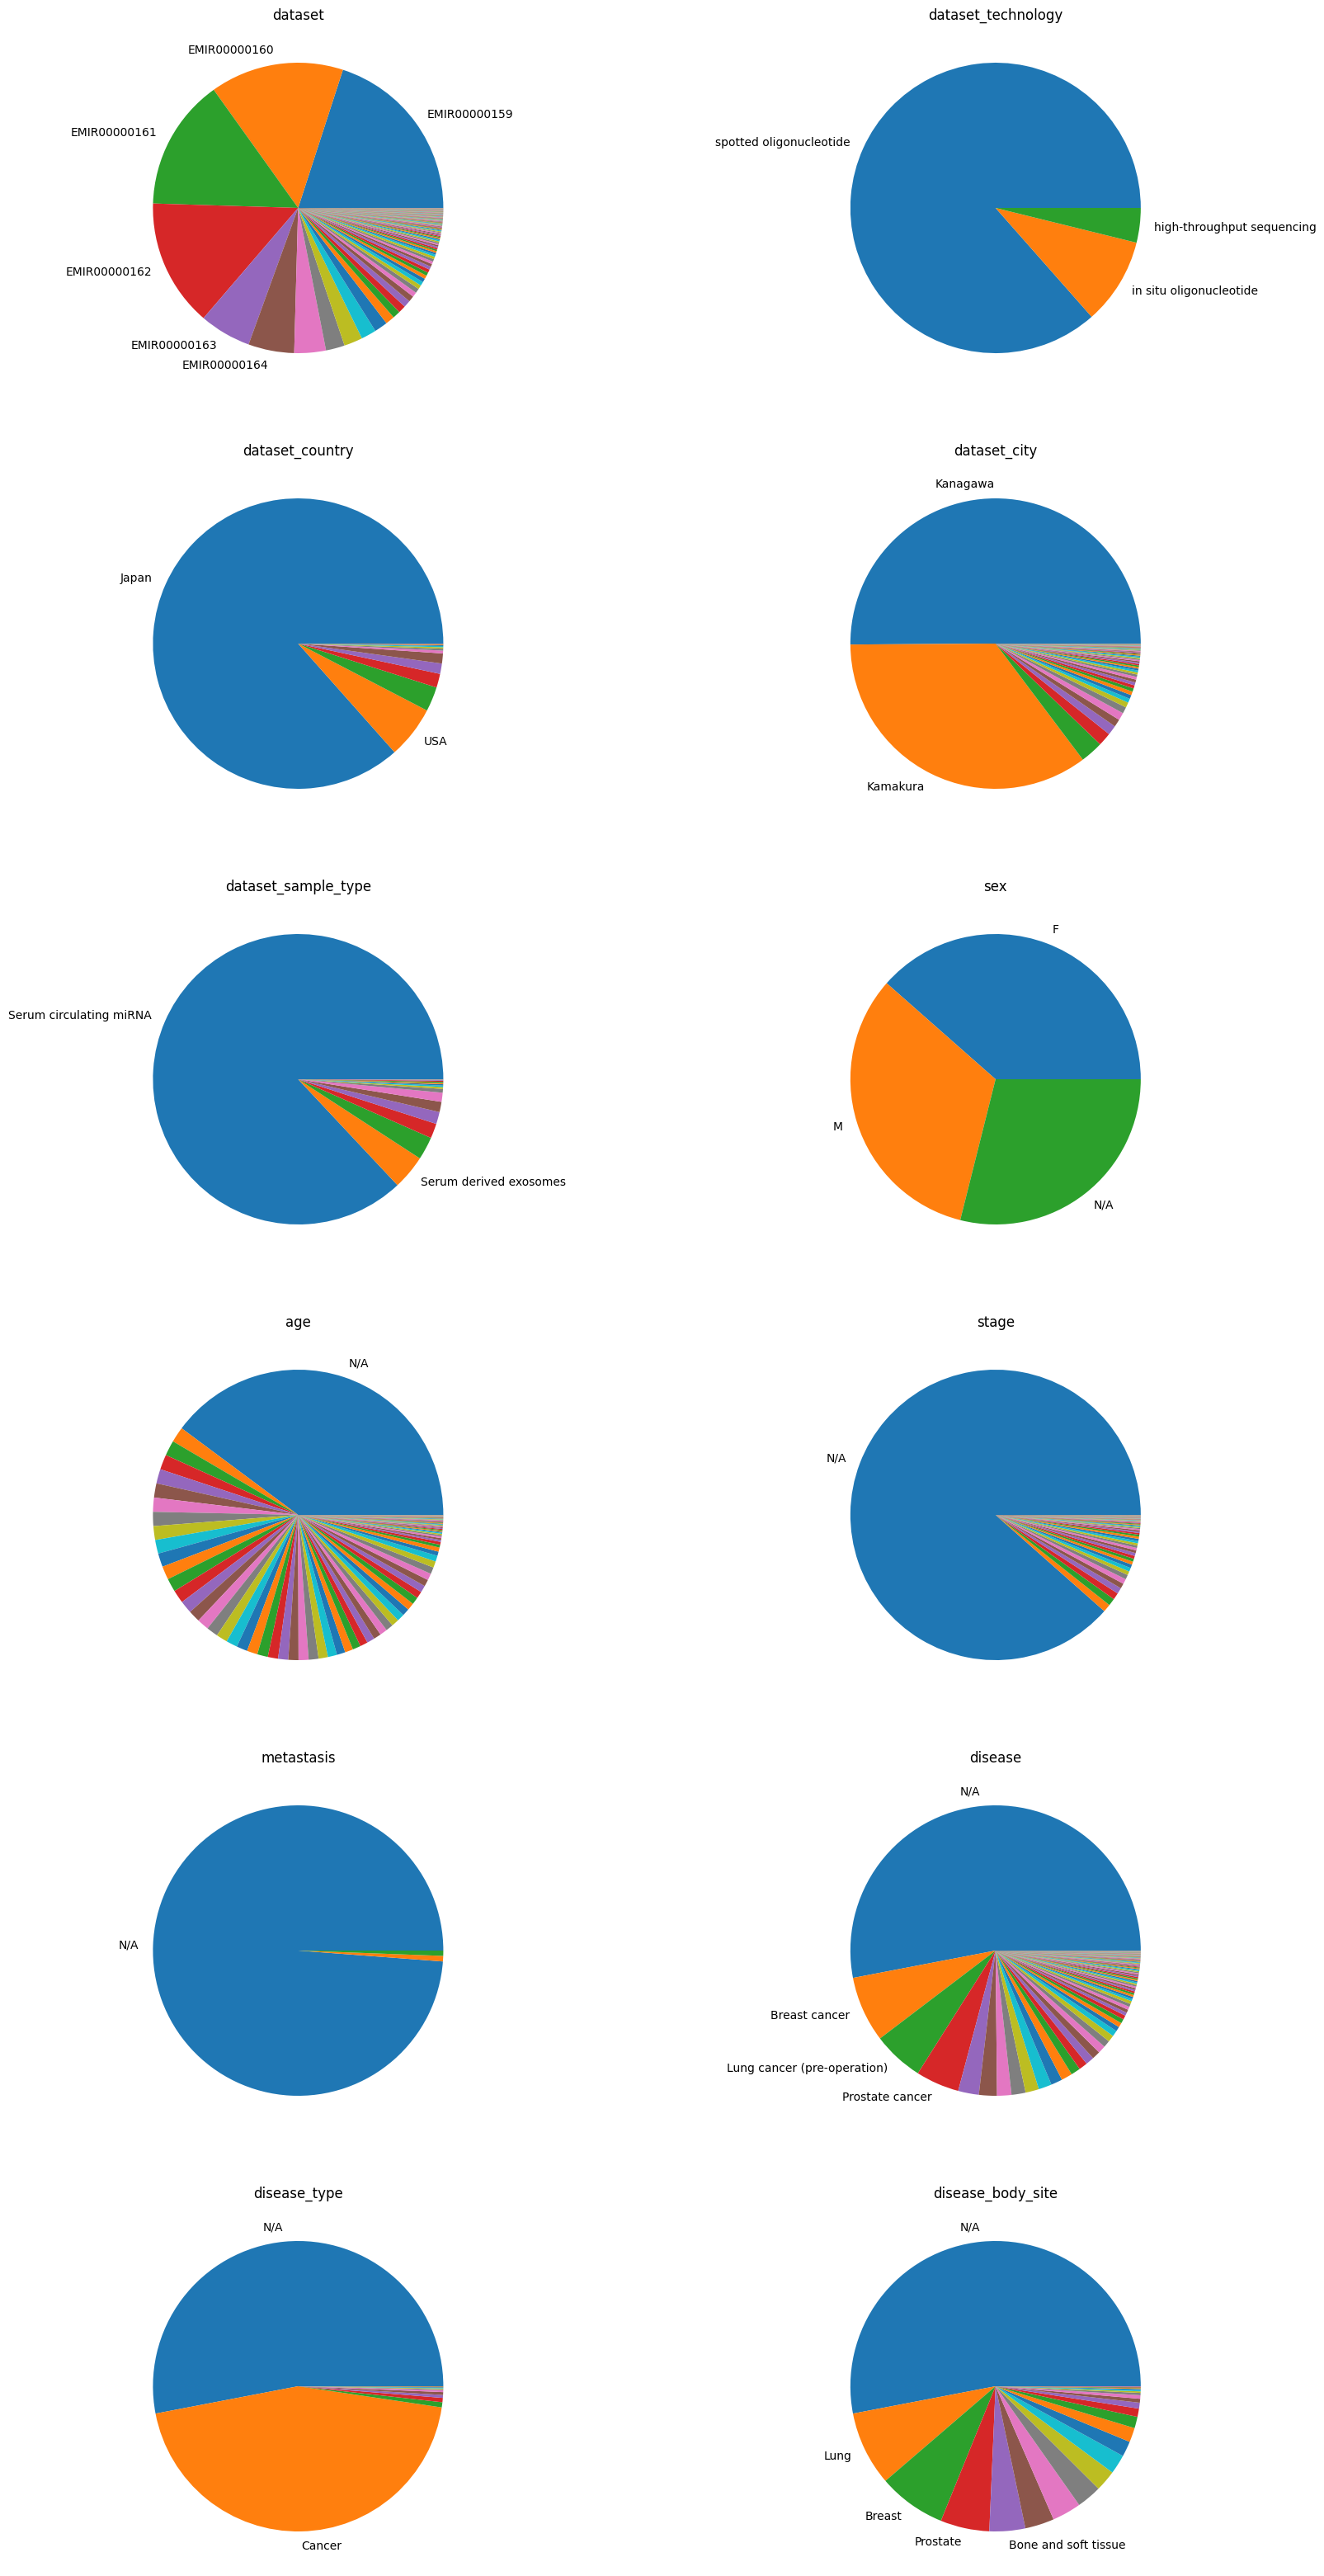

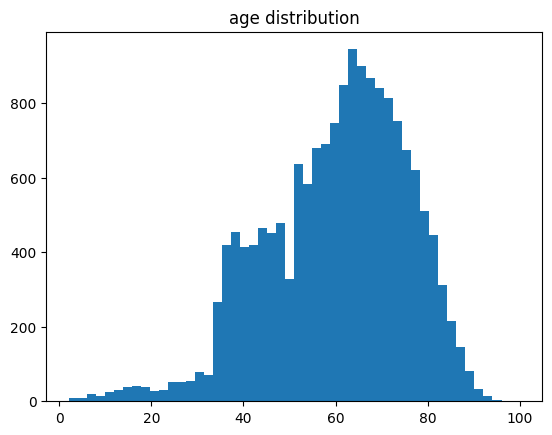

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data/PD.csv', index_col='sample_id')
print(f'\033[1mTotal samples: {len(df)}\033[0m')

fig, axs = plt.subplots(6, 2, figsize=(20, 40))
for i, column in enumerate(df.columns):

    counts = df[column].value_counts(dropna=False)
    labels = [label if count > 1000 else '' for count, label in zip(counts, counts.index)]
    labels = ['N/A' if pd.isnull(label) else label for label in labels]
    axs[i//2, i%2].set_title(f'{column}')
    axs[i//2, i%2].pie(counts, labels=labels)

plt.show()
plt.hist(df['age'], bins=50)
plt.title('age distribution')
plt.show()

# Issues


- Previous experiment: *disease* attribute extracted from dataset table but each dataset contains multiple diseases and healthy samples.

- Dataset integration is not recommended. If values in multiple datasets are not comparable, generated results are biased:

  - Different datasets use different value range: model will map the dataset range to its disease.

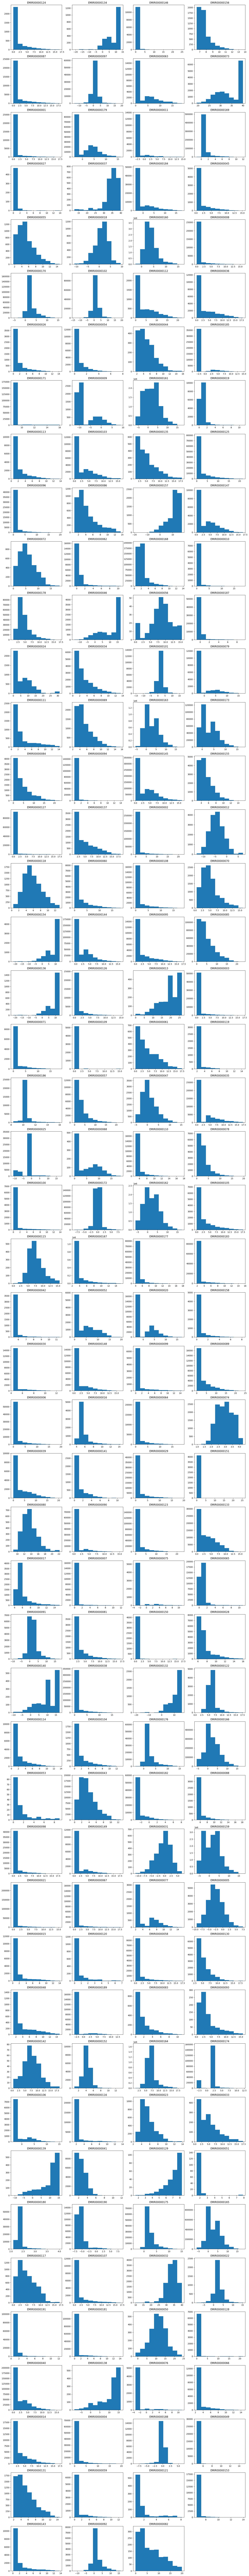

In [31]:
import glob
import pandas as pd
import matplotlib.pyplot as plt


fig, axs = plt.subplots(48, 4, figsize=(20, 220))
for i, filename in enumerate(glob.glob('data/raw/exp/*.csv')):
    values = pd.read_csv(filename, index_col=0).values.flatten()
    axs[i//4, i%4].hist(values)
    axs[i//4, i%4].set_title(filename.split('/')[-1][:-8])
    
axs[-1, -1].set_visible(False)

plt.show()

- Select datasets and diseases:

  - Frequency threshold

  - Absence of healthy samples (some datasets consider specific aspects of a particular disease)

- Select miRNA:

  - Frequency threshold
    
  - Presence of separators: ...|...|...

- Interpret miRNA values equal to 0.

- Meaning of *metastasis* and *stage* is dataset-specific.

- Aggregate *disease* and *stage* values.

- Define graph structure.

# Graph Construction

### Deep Graph Library:
An easy-to-use, high performance and scalable Python package for deep learning on graphs.

DGL represents each node by a unique integer (ID) and each edge by a pair of integers corresponding to the IDs of its end nodes. Each edge is assigned a unique integer, based on the order in which it was added to the graph. The numbering of node and edge IDs starts from 0. All the edges are directed and an edge (𝑢,𝑣) indicates that the direction goes from node 𝑢 to node 𝑣.

Nodes and edges can have several user-defined features. Only features of numerical types are allowed. They can be scalars, vectors or multi-dimensional tensors. For categorical attributes, consider converting them to integers or one-hot encoding. A feature has a unique name and is created via tensor assignment, which assigns a feature to each node/edge in the graph. You cannot assign a feature to a subset of the nodes/edges. For weighted graphs, you can store the weights as an edge feature.

A heterogeneous graph (heterograph) can have nodes and edges of different types. Nodes/edges of different types have independent ID space and feature storage. The metagraph associated with a heterogeneous graph is the schema of the graph. It specifies type constraints on the sets of nodes and edges between the nodes. A node 𝑢 in a metagraph corresponds to a node type in the associated heterograph. An edge (𝑢,𝑣) in a metagraph indicates that there are edges from nodes of type 𝑢 to nodes of type 𝑣 in the associated heterograph.

DGL follows the message passing paradigm. Message passing is directional: the message sent from one node 𝑢 to other node 𝑣 is not necessarily the same as the other message sent from node 𝑣 to node 𝑢 in the opposite direction.

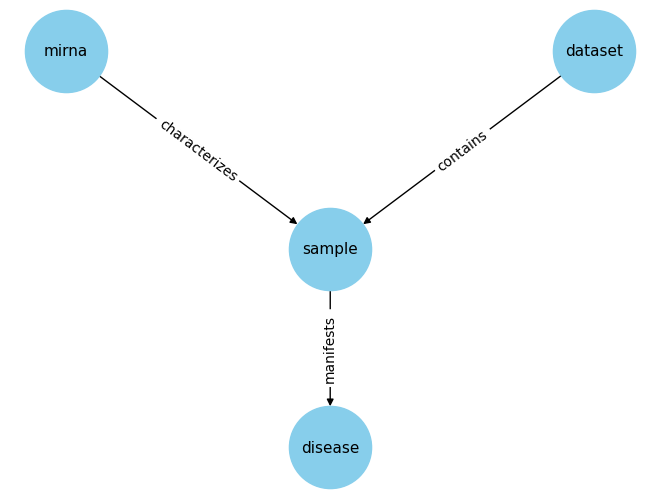

Node features
dataset        : ['technology', 'country', 'city', 'sample_type']
disease        : ['type', 'body_site']
mirna          : []
sample         : ['sex', 'age']

Edge features
contains       : []
characterizes  : ['value']
manifests      : ['stage', 'metastasis']

Node number
dataset        : 137
disease        : 115
mirna          : 8165
sample         : 27649

Edge number
contains       : 27649
characterizes  : 64926240
manifests      : 12990


In [32]:
import pandas as pd
import numpy as np
import dgl
import torch
import matplotlib.pyplot as plt
import networkx as nx


samples = pd.read_csv('data/PD.csv', index_col=0).sort_index().reset_index(drop=True)
unhealthy_samples = samples[samples['disease'].notnull()]

mirna = pd.read_csv('data/EXP.csv', index_col=0).sort_index()
rows, cols = np.where(~np.isnan(mirna))

# Construct graph by specifying the list of source and destination nodes for each relation (source node type, edge type, destination node type).
graph = dgl.heterograph({
   ('dataset', 'contains', 'sample'): (samples.dataset.factorize()[0], samples.index.tolist()),
   ('sample', 'manifests', 'disease'): (unhealthy_samples.index.tolist(), unhealthy_samples.disease.factorize()[0]),
   ('mirna', 'characterizes', 'sample'): (cols, rows)
})

# Set features for nodes of type 'sample'
graph.nodes['sample'].data['sex'] = torch.tensor(pd.get_dummies(samples['sex'], dtype=int).values)
graph.nodes['sample'].data['age'] = torch.tensor(samples['age'].values, dtype=int)

# Set features for nodes of type 'dataset'
datasets = samples.loc[:, samples.columns.str.startswith('dataset')].groupby('dataset').first()
for feature in datasets.columns:
   graph.nodes['dataset'].data[feature.split('_', 1)[-1]] = torch.tensor(pd.get_dummies(datasets[feature], dtype=int).values)

# Set features for nodes of type 'disease'
diseases = samples.loc[:, samples.columns.str.startswith('disease')].groupby('disease').first()
for feature in diseases.columns:
   graph.nodes['disease'].data[feature.split('_', 1)[-1]] = torch.tensor(pd.get_dummies(diseases[feature], dtype=int).values)

# Set features for edges of type 'manifests'
graph.edges['manifests'].data['stage'] = torch.tensor(pd.get_dummies(unhealthy_samples['stage'], dtype=int).values)
graph.edges['manifests'].data['metastasis'] = torch.tensor(pd.get_dummies(unhealthy_samples['metastasis'], dtype=int).values)

# Set features for edges of type 'expresses'
graph.edges['characterizes'].data['value'] = torch.tensor(mirna.values[rows, cols])

# Save graph
dgl.save_graphs("graph.dgl", graph)

# Visualize metagraph
pos = nx.kamada_kawai_layout(graph.metagraph())
nx.draw(graph.metagraph(), pos, with_labels=True, node_size=3500, font_size=11, node_color='skyblue')
nx.draw_networkx_edge_labels(graph.metagraph(), pos, edge_labels={(etype[0], etype[2]): etype[1] for etype in graph.canonical_etypes})
plt.show()

# Visualize graph properties
print(f'\033[1mNode features\033[0m')
for ntype in graph.ntypes:
   print(f'{ntype:<15}:', list(graph.nodes[ntype].data.keys()))

print(f'\033[1m\nEdge features\033[0m')
for etype in graph.etypes:
   print(f'{etype:<15}:', list(graph.edges[etype].data.keys()))

print(f'\033[1m\nNode number\033[0m')
for ntype in graph.ntypes:
   print(f'{ntype:<15}:', graph.number_of_nodes(ntype))

print(f'\033[1m\nEdge number\033[0m')
for etype in graph.etypes:
   print(f'{etype:<15}:', graph.number_of_edges(etype))